# Data Challenge 1
## Karla Knudson Oct. 11, 2018

 #### I built a model that predicts whether a biopsied breast cell is benign (not harmful) or malignant (cancerous), given a set of attributes about the cell. Since this is a classification problem, I used logistic regression.

In [52]:
import seaborn as sns
from matplotlib import pyplot
import numpy as np
import pandas as pd

### Import Data

In [53]:
df = pd.read_csv('/Users/knudsonk/Desktop/breast_cell_data.csv')

In [54]:
df['class'] = df['class'].replace(to_replace={4:1,2:0})
# Changing the class designations: benign = 0 and malign = 1
df

,id,clump_thickness,uniform_cell_size,uniform_cell_shape,marginal_adhesion,epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0
5,1017122,8,10,10,8,7,10,9,7,1,1
6,1018099,1,1,1,1,2,10,3,1,1,0
7,1018561,2,1,2,1,2,1,3,1,1,0
8,1033078,2,1,1,1,2,1,1,1,5,0
9,1033078,4,2,1,1,2,1,2,1,1,0


### Exploratory Data Analysis

#### Check for null values in the data

In [55]:
df.isnull().sum()

id                    0
clump_thickness       0
uniform_cell_size     0
uniform_cell_shape    0
marginal_adhesion     0
epithelial_size       0
bare_nuclei           0
bland_chromatin       0
normal_nucleoli       0
mitoses               0
class                 0
dtype: int64

##### There are no null values in the data

#### See what types of data are in the dataframe

In [56]:
df.dtypes

id                     int64
clump_thickness        int64
uniform_cell_size      int64
uniform_cell_shape     int64
marginal_adhesion      int64
epithelial_size        int64
bare_nuclei           object
bland_chromatin        int64
normal_nucleoli        int64
mitoses                int64
class                  int64
dtype: object

#### Since bare_nuclei is an object, rather than an integer, I will see if the data associated with that variable have unusable values

In [57]:
df.bare_nuclei.value_counts() #count the number of values in the bare_nuclei column

1     402
10    132
5      30
2      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: bare_nuclei, dtype: int64

#### The bare_nuclei have 16 "?" values, which need to be addressed. I will remove the samples containing these missing values.

In [58]:
df = df.replace('?', np.NaN) # replacing "?" with NaN
df = df.dropna() # dropping the NaN values
df.bare_nuclei.value_counts() #checking to make sure the ? and NaN values are gone

1     402
10    132
5      30
2      30
3      28
8      21
4      19
9       9
7       8
6       4
Name: bare_nuclei, dtype: int64

#### Modify the dataframe to include only the desired parameters. Since ID number is an arbitrary number that I do not expect to predict cancer class, I will remove it.

In [59]:
df.drop('id', axis=1, inplace=True) # get rid of the id column; inplace=True means it will be changed forever

#### Here I look at correlations between variables using a correlation matrix that includes all of the given features. Looking at this, one can observe that there are some strong correlations between many variables (especially cell size and shape, where r=0.91). However, there may also be non-linear relationships between variables and/or complex interactions between features that are not adequately reflected in this correlation matrix.

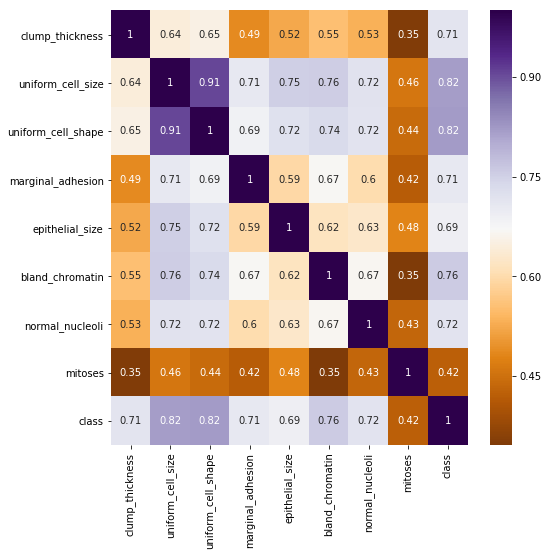

In [60]:
corr_matrix=df.corr()
pyplot.figure(figsize=(8,8))
sns.heatmap(corr_matrix, cmap='PuOr', annot = True)

### See if the data are balanced

In [62]:
count_benign = len(df[df['class']==0])
print(count_benign)

count_malign = len(df[df['class']==1])
print(count_malign)

pct_benign = count_benign/(count_benign+count_malign)
print("percentage of benign cells:", pct_benign*100)

pct_malign = count_malign/(count_benign+count_malign)
print("percentage of malignant cells:", pct_malign*100)

444
239
percentage of benign cells: 65.00732064421669
percentage of malignant cells: 34.99267935578331


#### There are 65% benign cell samples and 35% malignant cell samples, so the data is somewhat imbalanced. However, I believe that the imbalance is not so severe that it will prevent the logistic regression model from performing well.

## Logistic Regression

#### Import scikit-learn packages

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#### Define the dependent and independent variables. Cancer 'class' is dependent, and all the other features are independent.

In [70]:
X = df.drop('class', axis=1) #get rid of the class column; axis = 1 refers to columns
y = df['class']

#### Conduct the test/train split, fit the data to the model using the training data, and create predictions on the test data

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
predictions = logreg.predict(X_test)

### Evaluation of Model Performance: Classification Report & Confusion Matrix

In [72]:
from sklearn.metrics import classification_report
score = (classification_report(y_test, predictions))
print (score)

             precision    recall  f1-score   support

          0       0.97      0.99      0.98       115
          1       0.98      0.93      0.95        56

avg / total       0.97      0.97      0.97       171



[[114   1]
 [  4  52]]


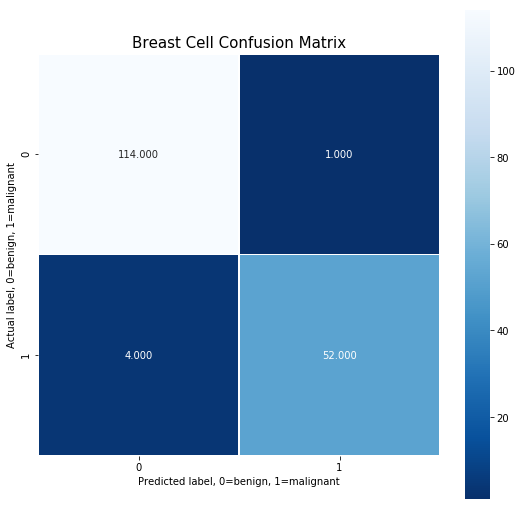

In [76]:
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label, 0=benign, 1=malignant');
plt.xlabel('Predicted label, 0=benign, 1=malignant');
plt.title('Breast Cell Confusion Matrix', size = 15);

## Summary of Results

#### The objective of this work was to build a model to predict whether a breast cell "class" is cancerous (malignant) or non-cancerous (benign), based on some given cell features. Exploratory data analyses showed that there were some relatively strong correlations between cancer "class" and other features, as well as strong relationships between the independent features themselves. Yet, it was still possible for cancer features to behave non-linearly or exhibit complex relationships. Since identifying cancerous and non-cancerous cells is a type of classification problem, I decided to first try modeling the data using logistic regression and use more complex models only if needed. Overall, results showed that logistic regression does a great job in classifying benign and malignant cells. Through this model, I was able to achieve 93% precision and 93% recall. Future work to try to improve the outcomes could include hypertuning the parameters to maximize recall. Since this is a cancer screening tool, it would be important to make sure that all possible malignant cases are identified (i.e., reduce the false negatives). Additionally future work could include trying a Random Forest Model, which could provide information about complex interactions between features. However, a more complex model may offer diminishing returns, given the excellent performance of the relatively simple model used here.